In [1]:
# General Utility functions
import os
import shutil
import pandas as pd
from PIL import Image 
import numpy as np
from pathlib import Path
import matplotlib as plt

# Tensorflow model import
import tensorflow  as tf
from tensorflow.keras import layers as tfkl
from MySqueezeNet import SqueezeNet

from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image



In [ ]:
# HIGH PRIORITY
# TODO: Include the test data in the test set, this could be either the test set or the val and test set - maybe put the download data script in a seperate script
# TODO: Figure out a way to get a confusion matrix and classification report
# TODO: Experiment with bringing the rescaling back, try other scaling and standardization techniques
# TODO: look at ways of loading the data without image_dataset_from_directory
# LOW PRIORITY
# TODO: Look into using a cache for loaded images
# TODO: Investigate message "filling up shuffle buffer"
# TODO: experiment with techniques to make white stand out more in images
# TODO: experiment with other hyperparamaters
# TODO: Experiment with data augmentation

In [2]:
# Defing Hyperparamaters
BATCH_SIZE = 50
SEED = 42 



def create_folder(path_name):
    if not path_name.is_dir():
        path_name.mkdir(parents=True)

def copy_file(src,dst):
    if dst.is_file():
        # if file exists then write behavior here.
        return 1
    else:
        shutil.copy(src, dst)

# This bit may be useful for loading the data faster 

DATA_DIR = r'Datasets/aptos2019-blindness-detection'

train_csv_path = DATA_DIR + '/train.csv'



In [8]:

import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

DATA_DIR = "C:\\git_repos\\Thesis\\data\\diabetic_retinopathy"
TRAIN_DIR = DATA_DIR + "\\train_set.csv"
VAL_DIR = DATA_DIR + "\\train_set.csv"

# Defing Hyperparamaters
BATCH_SIZE = 50
SEED = 42
# Load dataframe
train_df = pd.read_csv(TRAIN_DIR)
val_df = pd.read_csv(VAL_DIR)

# Split dataframe into train and validation sets
#train_df, val_df = train_test_split(df, test_size=0.1, random_state=SEED)


def load_image(file_name):
    raw = tf.io.read_file(file_name)
    tensor = tf.io.decode_image(raw)
    tensor = tf.cast(tensor, tf.float32) / 255.0
    return tensor


def create_dataset(file_names, labels):
    dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))
    dataset = dataset.map(lambda file_name, label: (load_image(file_name), label))
    return dataset

train_df["file_name"] = DATA_DIR + "\\images\\" + train_df["id_code"] + ".png"
train_file_names = train_df["file_name"].to_numpy()
train_labels = train_df["diagnosis"].to_numpy()
train_ds = create_dataset(train_file_names, train_labels)

val_df["file_name"] = DATA_DIR + "\\images\\" + val_df["id_code"] + ".png"
val_file_names = val_df["file_name"].to_numpy()
val_labels = val_df["diagnosis"].to_numpy()
val_ds = create_dataset(val_file_names, val_labels)

In [6]:
train_df['id_code'].values

array(['a2163f0c2af5', '917f76f360b6', '0709652336e2', ...,
       '62b826899151', '721214151233', '4c78d9d18da9'], dtype=object)

In [3]:
df_train = pd.read_csv(train_csv_path)

# TODO: See if this can be more efficient, ie. check if it has already been done
# split all the images into the foldair according to their label
for diagnosis, group in df_train.groupby('diagnosis'):
    path_name = Path(DATA_DIR).joinpath('train', 'class_' +  str(diagnosis))
    create_folder(path_name)
    image_class_names = list(group['id_code'])
    class_paths = [Path(DATA_DIR).joinpath('train_images', name + '.png') for name in image_class_names]
    new_paths = [path_name.joinpath(name + '.png') for name in image_class_names]
    print(f'Class: {diagnosis}, Count: {len(image_class_names)}')
    for src, dst in zip(class_paths, new_paths):
        shutil.copy(src, dst)




#create train and test datasets
        
train_ds = tf.keras.utils.image_dataset_from_directory(Path(DATA_DIR).joinpath('train'),
                                                    validation_split=0.1,
                                                    subset="training",
                                                    color_mode='rgb',
                                                    seed=SEED,
                                                    image_size=(265, 265),  # This resizes the image, using bilinear transformation
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True
                                                    )

val_ds = tf.keras.utils.image_dataset_from_directory(Path(DATA_DIR).joinpath('train'),
                                                    validation_split=0.1,
                                                    subset="validation",
                                                    color_mode='rgb',
                                                    seed=SEED,
                                                    image_size=(265, 265),  # This resizes the image, using bilinear transformation
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True
                                                    )



Class: 0, Count: 1805
Class: 1, Count: 370
Class: 2, Count: 999
Class: 3, Count: 193
Class: 4, Count: 295
Found 3662 files belonging to 5 classes.
Using 3296 files for training.
Found 3662 files belonging to 5 classes.
Using 366 files for validation.


In [4]:
print(val_ds.class_names)

['class_0', 'class_1', 'class_2', 'class_3', 'class_4']


In [10]:
import matplotlib.pyplot as plt

class_names = train_ds.labels

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    print(class_names[labels[i]])
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

AttributeError: '_MapDataset' object has no attribute 'labels'

In [7]:
# could probably work batch count out but this is clearer
# split validation into test and val
# TODO:print the size of these datasets
#val_batches = tf.data.experimental.cardinality(val_ds)
#test_ds = val_ds.take((2*val_batches) // 3)
#val_ds = val_ds.skip((2*val_batches) // 3)


data_prep = tf.keras.Sequential([
        #tfkl.Rescaling(1./255),
        tfkl.CenterCrop(224, 224)
])


data_augmentation = tf.keras.Sequential([
    data_prep,
    tfkl.RandomFlip("horizontal")
])


#prepare the datasets
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
val_ds = val_ds.map(lambda x, y: (data_prep(x), y))
#test_ds = test_ds.map(lambda x, y: (data_prep(x), y))
 

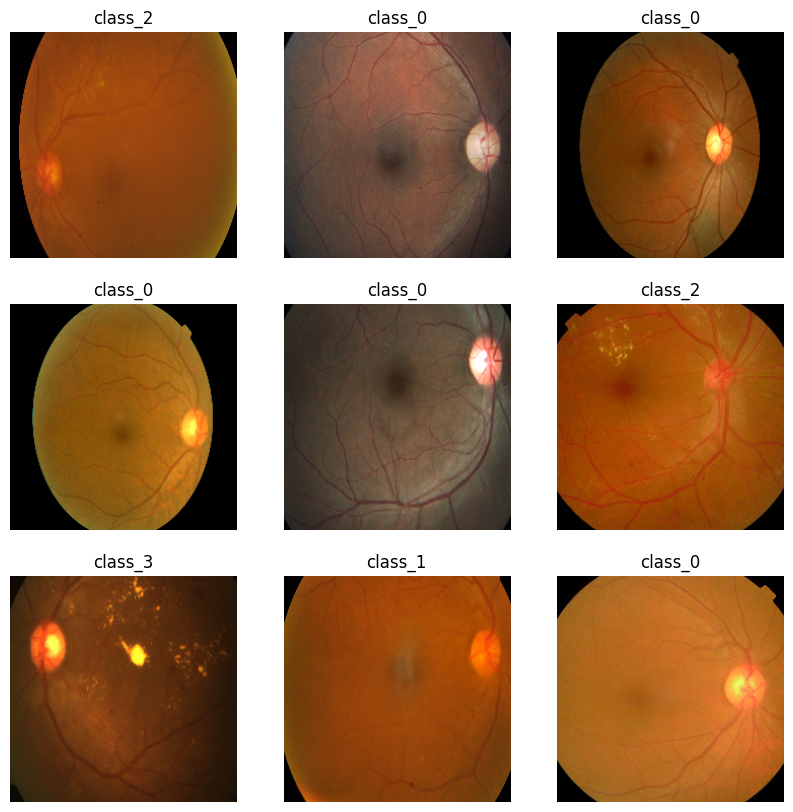

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

class_0
class_0
class_2
class_2
class_0
class_0
class_1
class_2
class_2


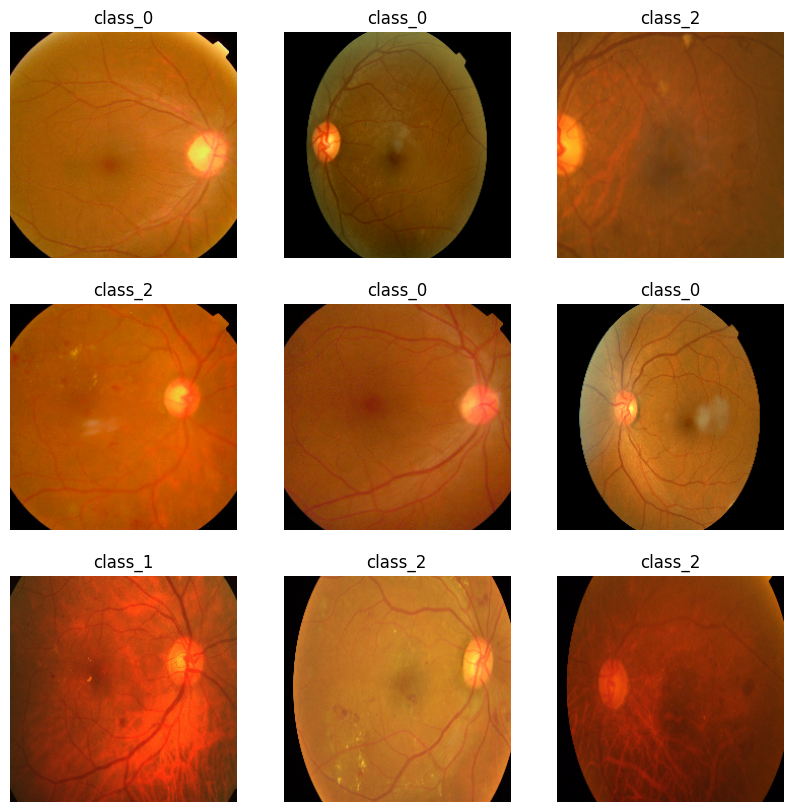

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    print(class_names[labels[i]])
    plt.axis("off")

In [10]:
count = np.zeros(5, dtype=np.int32)
for _, labels in train_ds:
    y, _, c = tf.unique_with_counts(labels)
    count[y.numpy()] += c.numpy()
print(count)

[1630  336  897  175  258]


In [11]:
count = np.zeros(5, dtype=np.int32)
for _, labels in val_ds:
    y, _, c = tf.unique_with_counts(labels)
    count[y.numpy()] += c.numpy()
print(count)

[175  34 102  18  37]


In [12]:
# create the model
model = SqueezeNet(include_top=False, input_shape=(224, 224, 3))

# tf.keras.optimizers.experimental.SGD(momentum=0.9)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

epochs=100

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 111, 111, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 relu_conv1 (Activation)     (None, 111, 111, 64)         0         ['conv1[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 55, 55, 64)           0         ['relu_conv1[0][0]']          
                                                                                            

In [13]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  #callbacks=[es,mc]
)





Epoch 1/100


66/66 [==============================] - 156s 2s/step - loss: 1.0165 - accuracy: 0.6505 - val_loss: 0.8903 - val_accuracy: 0.6995
Epoch 2/100
66/66 [==============================] - 138s 2s/step - loss: 0.8844 - accuracy: 0.7057 - val_loss: 0.8965 - val_accuracy: 0.7077
Epoch 3/100
66/66 [==============================] - 127s 2s/step - loss: 0.8392 - accuracy: 0.7169 - val_loss: 0.8835 - val_accuracy: 0.6995
Epoch 4/100
66/66 [==============================] - 127s 2s/step - loss: 0.8073 - accuracy: 0.7245 - val_loss: 0.8325 - val_accuracy: 0.6885
Epoch 5/100
66/66 [==============================] - 129s 2s/step - loss: 0.7560 - accuracy: 0.7279 - val_loss: 0.8082 - val_accuracy: 0.7104
Epoch 6/100
66/66 [==============================] - 127s 2s/step - loss: 0.7171 - accuracy: 0.7503 - val_loss: 0.7908 - val_accuracy: 0.7213
Epoch 7/100
66/66 [==============================] - 126s 2s/step - loss: 0.6782 - accuracy: 0.7561 - val_loss: 0.7443 - val_accuracy: 0.7213
Epoc

In [ ]:
saved_model = load_model('ShuffledVal.h5')

In [ ]:
import matplotlib.pyplot as plt

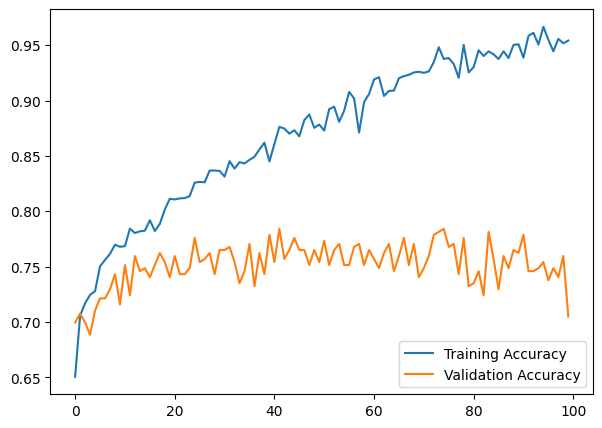

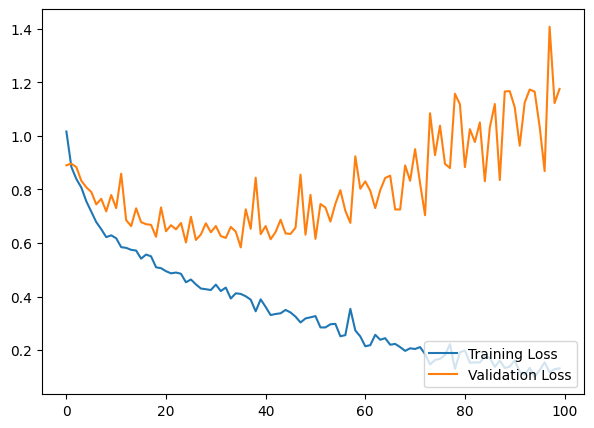

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# PLot the dataset and save it
fig1, ax1 = plt.subplots(figsize=(7,5))
ax1.plot(epochs_range, acc, label='Training Accuracy')
ax1.plot(epochs_range, val_acc, label='Validation Accuracy')
ax1.legend(loc="lower right")

fig1.savefig("Figures\\TrainingValidationAccuracy")

# PLot the dataset and save it
fig2, ax2 = plt.subplots(figsize=(7,5))

ax2.plot(epochs_range, loss, label='Training Loss')
ax2.plot(epochs_range, val_loss, label='Validation Loss')
ax2.legend(loc="lower right")
fig2.savefig("Figures\\TrainingValidationLoss")


In [19]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [27]:
y_predict = model.predict(val_ds)

8/8 [==============================] - 8s 370ms/step


In [32]:
y_predict

array([[3.5539453e-04, 3.1465787e-01, 6.6440630e-01, 1.9608960e-02,
        9.7152108e-04],
       [3.5806954e-02, 2.4811757e-01, 7.0247769e-01, 8.3858809e-03,
        5.2118842e-03],
       [7.7577233e-01, 2.1715106e-01, 6.7398138e-03, 3.2837066e-04,
        8.4129206e-06],
       ...,
       [9.9354941e-01, 6.4457431e-03, 4.5925171e-06, 1.9016559e-08,
        1.7914657e-07],
       [9.7636026e-01, 2.3581333e-02, 5.8313861e-05, 7.2975823e-08,
        2.7683235e-08],
       [2.5343632e-09, 2.0689683e-09, 4.9077986e-05, 5.8205235e-01,
        4.1789857e-01]], dtype=float32)

In [28]:
predicted_cats = np.argmax(y_predict, axis=1)
predicted_cats

array([2, 2, 0, 2, 0, 3, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2,
       0, 2, 2, 1, 4, 2, 2, 3, 2, 1, 0, 1, 2, 0, 2, 0, 1, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 2, 2, 1, 1, 3, 0, 2, 2, 2, 0, 0, 0, 4, 0, 2, 0,
       2, 0, 2, 0, 3, 3, 0, 3, 0, 0, 0, 0, 0, 2, 2, 1, 1, 3, 2, 0, 0, 2,
       0, 1, 0, 2, 2, 0, 0, 4, 2, 1, 3, 4, 2, 3, 2, 1, 2, 0, 0, 2, 0, 0,
       2, 3, 2, 0, 2, 0, 3, 0, 3, 2, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 2, 0,
       2, 1, 0, 1, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 1, 0, 0,
       0, 0, 0, 2, 2, 2, 2, 2, 2, 3, 0, 2, 2, 1, 3, 0, 0, 0, 2, 1, 1, 1,
       3, 0, 0, 0, 2, 0, 2, 2, 3, 2, 3, 0, 0, 0, 2, 0, 0, 0, 1, 2, 3, 2,
       0, 2, 0, 0, 0, 2, 1, 1, 0, 0, 2, 0, 1, 2, 0, 0, 2, 2, 0, 2, 2, 0,
       2, 2, 3, 2, 4, 4, 2, 0, 0, 0, 0, 4, 2, 0, 2, 1, 0, 3, 0, 3, 0, 0,
       0, 0, 2, 2, 2, 2, 0, 1, 0, 0, 2, 2, 4, 0, 0, 2, 0, 4, 0, 0, 1, 2,
       0, 0, 1, 0, 2, 2, 3, 2, 1, 0, 2, 0, 2, 2, 3, 4, 0, 0, 3, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 0, 2, 4, 0, 0,

In [33]:
true_cats = tf.concat([(y, model.predict(x)) for x, y in val_ds], axis=0).numpy()

1/1 [==============================] - 0s 99ms/step


InvalidArgumentError: {{function_node __wrapped__Pack_N_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Shapes of all inputs must match: values[0].shape = [50] != values[1].shape = [50,5] [Op:Pack] name: 

In [ ]:
true_cats

array([2, 2, 4, 2, 4, 0, 0, 0, 0, 0, 2, 0, 3, 4, 1, 0, 1, 2, 0, 0, 0, 0,
       1, 2, 4, 0, 0, 3, 0, 2, 1, 0, 0, 0, 0, 0, 0, 3, 0, 2, 4, 2, 0, 0,
       0, 0, 4, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 1, 3, 0,
       0, 1, 4, 4, 2, 0, 2, 0, 0, 0, 0, 4, 0, 4, 4, 2, 0, 2, 0, 0, 2, 0,
       1, 2, 0, 0, 0, 0, 2, 0, 4, 0, 4, 0, 2, 0, 3, 3, 0, 1, 2, 0, 2, 2,
       0, 2, 0, 2, 1, 0, 0, 0, 0, 4, 1, 0, 2, 2, 4, 1, 3, 0, 0, 3, 0, 0,
       2, 4, 1, 2, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 4, 2, 2, 2, 0, 0, 0,
       2, 0, 0, 1, 1, 2, 2, 4, 0, 0, 4, 0, 2, 4, 2, 1, 2, 1, 0, 0, 4, 2,
       2, 0, 4, 0, 2, 0, 0, 0, 2, 0, 0, 0, 4, 2, 4, 0, 0, 2, 1, 0, 0, 4,
       2, 0, 0, 0, 2, 0, 0, 1, 1, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 3,
       0, 0, 0, 2, 4, 2, 2, 2, 3, 0, 0, 2, 0, 4, 0, 0, 2, 0, 2, 2, 2, 0,
       2, 4, 1, 2, 1, 1, 0, 2, 0, 2, 0, 4, 1, 2, 1, 0, 0, 0, 0, 0, 0, 4,
       0, 4, 0, 2, 0, 2, 0, 2, 3, 0, 0, 2, 3, 2, 0, 0, 1, 1, 0, 3, 0, 0,
       0, 0, 1, 0, 2, 2, 2, 2, 0, 0, 4, 2, 2, 0, 2,

In [31]:
print(classification_report(true_cats, predicted_cats))

              precision    recall  f1-score   support

           0       0.46      0.41      0.43       175
           1       0.06      0.06      0.06        34
           2       0.27      0.34      0.30       102
           3       0.00      0.00      0.00        18
           4       0.07      0.03      0.04        37

    accuracy                           0.30       366
   macro avg       0.17      0.17      0.17       366
weighted avg       0.31      0.30      0.30       366



In [26]:
test_loss, test_acc = model.evaluate(train_ds, verbose=2)

print('\nTest accuracy:', test_acc)

66/66 - 85s - loss: 0.1955 - accuracy: 0.9323 - 85s/epoch - 1s/step

Test accuracy: 0.9323422312736511


In [ ]:
list(val_ds.as_numpy_iterator())[0]

(array([[[[0.00392157, 0.00392157, 0.        ],
          [0.00392157, 0.00392157, 0.        ],
          [0.00392157, 0.00392157, 0.        ],
          ...,
          [0.00240479, 0.00240479, 0.00240479],
          [0.00392157, 0.00392157, 0.00392157],
          [0.00392157, 0.00392157, 0.00392157]],
 
         [[0.00392157, 0.00392157, 0.        ],
          [0.00392157, 0.00392157, 0.        ],
          [0.00392157, 0.00392157, 0.        ],
          ...,
          [0.00240479, 0.00240479, 0.00240479],
          [0.00392157, 0.00392157, 0.00392157],
          [0.00392157, 0.00392157, 0.00392157]],
 
         [[0.00392157, 0.00392157, 0.        ],
          [0.00392157, 0.00392157, 0.        ],
          [0.00392157, 0.00392157, 0.        ],
          ...,
          [0.00392157, 0.00392157, 0.00392157],
          [0.00392157, 0.00392157, 0.00392157],
          [0.00392157, 0.00392157, 0.00392157]],
 
         ...,
 
         [[0.        , 0.        , 0.        ],
          [0.     

In [ ]:

img_path = 'C:\\git_repos\\Thesis\\Datasets\\aptos2019-blindness-detection\\train\\class_3\\0b14014117d.png'

img = tf.keras.utils.load_img(
    img_path, target_size=(224, 224)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = saved_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\git_repos\\Thesis\\Datasets\\aptos2019-blindness-detection\\train\\class_3\\0b14014117d.png'

In [ ]:
predictions

array([[0., 0., 1., 0., 0.]], dtype=float32)